In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import math
import pandas as pd
from scipy import stats , optimize , odr
from scipy.optimize import minimize
import os



In [2]:

def extract_time_and_channel(directory): 
    data_flipped = []
    normal_data = []

    for file in os.listdir(directory):
        if file.endswith("flipped.csv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path, comment="#")
            data_flipped.append( df[["Time (s)", "Channel 1 (V)"]].to_numpy())
        elif file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path, comment="#")
            normal_data.append( df[["Time (s)", "Channel 1 (V)"]].to_numpy())  

    for i in range(len(normal_data)):
        normal_data[i] = normal_data[i].T
        data_flipped[i] = data_flipped[i].T
        
    return normal_data, data_flipped



def error_mean(data: list, n: int) -> float:
    ''' 

    This function calculates the error on the mean. Suitable for when we have several data points without errors, e.g. the periods.

    Arguments:
        data (list / numpy.array): input data
        n (int): number of data points
    
    Returns:
        (float / np.float): error on the mean

    '''
    return np.std(data)/np.sqrt(n)



def error_mean_measured(data: list, n: int, error: float) -> float:
    '''
    This function calculates the total error of a quanitity with several measurements with the same error, e.g. the laser lengths. 
      
    Arguments:
        data (list / np.array): input data
        n (int): number of data samples
        error (float): error of all the measurements (all equal)
        
        
    Returns:
        (float / np.float): error as sum of error of the mean and error propagation
        
    '''
    return np.sqrt((error_mean(data,n)**2 + error**2))



def fit_func(t, s0, v, a):
    return 0.5 * a * t**2 + v * t + s0


def chi2(params, x, y, x_err, y_err):

    s0, v, a = params
    model = fit_func(x, s0, v, a)
    partial_derivative = v + a * x  # Partial derivative of the model w.r.t. x
    effective_var = y_err**2 + (partial_derivative * x_err)**2
    return np.sum(((y - model) ** 2) / effective_var)

def find_fit_chi2(x, x_err, y, y_err, params0):

    result = minimize(chi2, params0, args=(x, y, x_err, y_err))
    params_fit = result.x
    s0_fit, v_fit, a_fit = params_fit

    hessian_inv = result.hess_inv if hasattr(result, 'hess_inv') else None
    param_errors = np.sqrt(np.diag(hessian_inv)) if hessian_inv is not None else [None] * 3

    sigmas0_fit, sigmav_fit, sigmaa_fit = param_errors

    model = fit_func(x, s0_fit, v_fit, a_fit)
    partial_derivative = v_fit + a_fit * x  
    effective_var = y_err**2 + (partial_derivative * x_err)**2
    chi2_val = np.sum(((y - model) ** 2) / effective_var)
    residuals = y - model

    return s0_fit, sigmas0_fit, v_fit, sigmav_fit, a_fit, sigmaa_fit, residuals, chi2_val

def plot_fit_chi2(x, x_err, y, y_err, params0):

    xplot = np.linspace(min(x), max(x), 1000)
    s0, ss0, v, sv, a, sa, res, chi2_val = find_fit_chi2(x, x_err, y, y_err, params0)

    plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', label="Data with errors")
    plt.plot(xplot, fit_func(xplot, s0, v, a), 'r-', label="Fit")
    plt.xlabel('Time (s)')
    plt.ylabel('Position (cm)')
    plt.legend()
    plt.grid()
    plt.show()

    return s0, ss0, v, sv, a, sa, res, chi2_val


def find_peak_middle(data, Vref):
    peaks = np.zeros((5,2))
    indices = np.where((data[1,:-1] < Vref) & (data[1,1:] > Vref) | (data[1,:-1] > Vref) & (data[1,1:] < Vref))[0]

    x_intersections = []
    for i in indices:
        x0, x1 = data[0,i], data[0,i+1]
        y0, y1 = data[1,i], data[1,i+1]
        x_inter = x0 + (Vref - y0) * (x1 - x0) / (y1 - y0)
        x_intersections.append(x_inter)
        
    peaks[:,0] = [sum(x_intersections[i:i+2]) for i in range(0, len(x_intersections),2)]
    peaks[:,0] = [x/2 for x in peaks[:,0]]
    peaks[:,1] = np.abs([sum([x_intersections[i], -x_intersections[i+1]]) for i in range(0, len(x_intersections),2)])
    peaks[:,1] = [x/2 for x in peaks[:,1]]

    return peaks
        

In [3]:
directory = "/Users/miguelalonsomediavilla/University/ApStats/Project/AppStats2024/Plane/data"  
ndata, fdata = extract_time_and_channel(directory)
# NOW FOR EVERY FLIPPED OR NOT FLIPPED, THE FIRST THREE ARE FOR BALL 1, THE NEXT THREE FOR BALL 2 AND THE NEXT THREE FOR BALL 3

positions_mig = np.flip(np.array([81.5, 65.33, 50.45, 35.25, 20.3]))
positions_mic = np.flip(np.array([80.8, 65.15, 50.35, 35.05, 20.15]))
positions_sar = np.flip(np.array([80.95, 65.15, 50.30, 35.05, 20.15]))
positions = [positions_mig, positions_mic, positions_sar]

for i in range(3):
    positions[i] = [x / 100 for x in positions[i]]


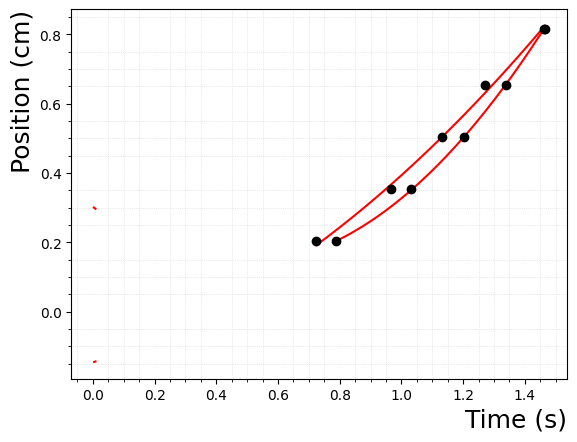

Ball 0
Acceleration normal:  1.4142570045815952 +- 0.05279628033202225
Acceleration flipped:  0.5297811920984131 +- 0.05525570902617601


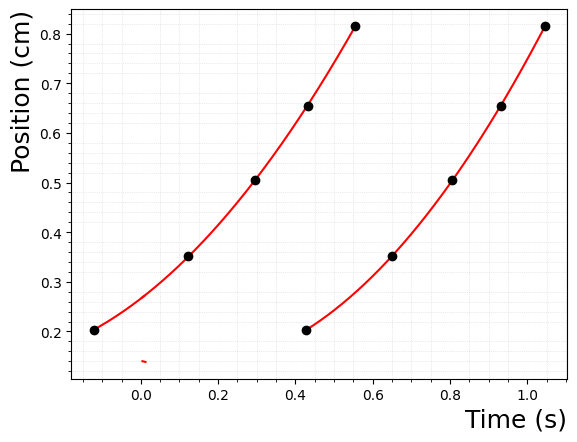

Ball 0
Acceleration normal:  1.396891895592451 +- 0.05081149136702147
Acceleration flipped:  1.615271276806904 +- 0.09500451285088121


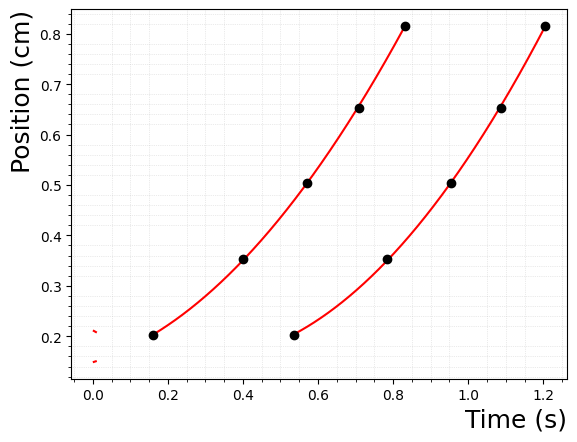

Ball 0
Acceleration normal:  1.3739312276736761 +- 0.05108003605687247
Acceleration flipped:  1.539129028491595 +- 0.051691516961345406


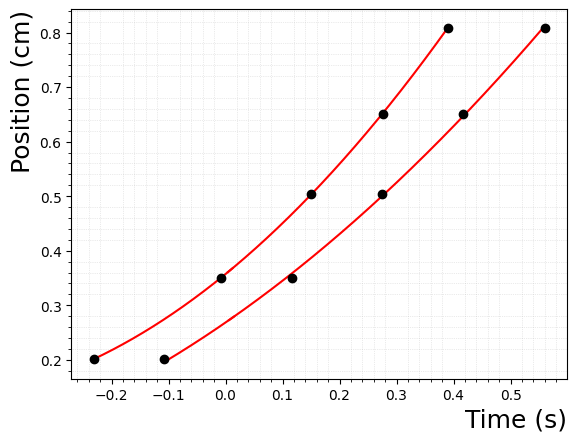

Ball 1
Acceleration normal:  1.5569856478513504 +- 0.09519229962461097
Acceleration flipped:  0.8917963660872306 +- 0.11206691390023538


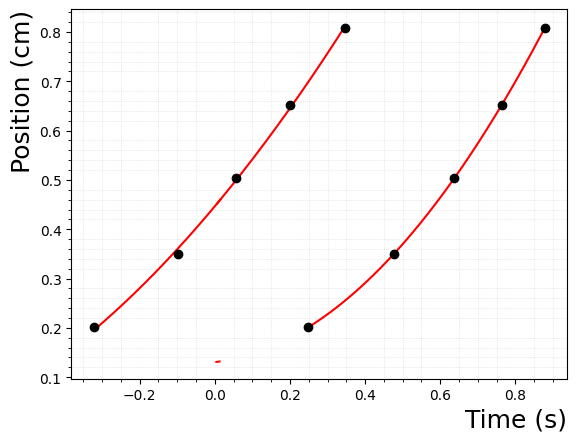

Ball 1
Acceleration normal:  0.8165555904229067 +- 0.03343298393922782
Acceleration flipped:  1.550478742156054 +- 0.09306205558971926


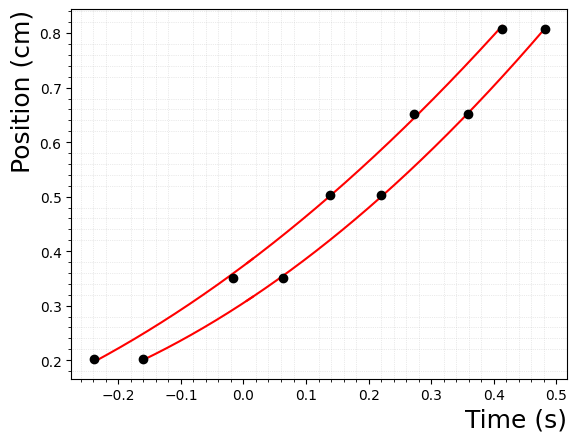

Ball 1
Acceleration normal:  1.2246017965966571 +- 0.11144338040476028
Acceleration flipped:  1.0039106334602625 +- 0.008561728423326158


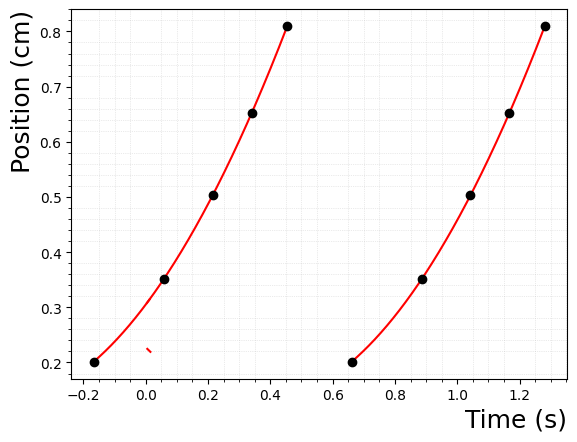

Ball 2
Acceleration normal:  1.5793846231283009 +- 0.09508302976647727
Acceleration flipped:  1.5941492825355723 +- 0.11443632507643058


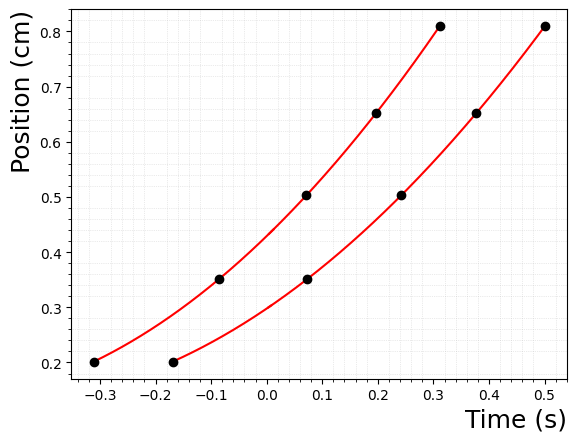

Ball 2
Acceleration normal:  1.5757820834658585 +- 0.09491192635392566
Acceleration flipped:  1.3557348274735839 +- 0.0027461987654861845


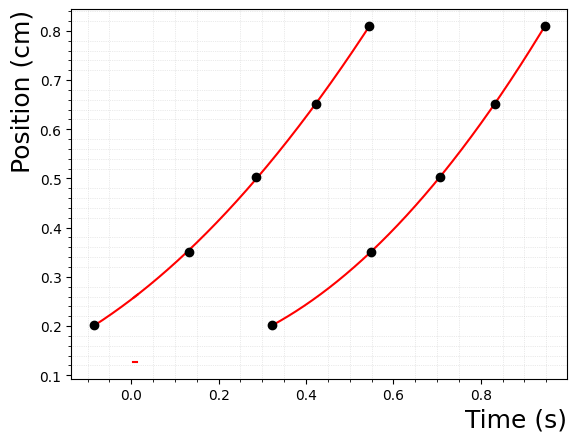

Ball 2
Acceleration normal:  1.254932234701527 +- 0.11424304298209038
Acceleration flipped:  1.5724324403953094 +- 0.09397552355616462


In [4]:

for i in range(9):
    npeak = find_peak_middle(ndata[i], 4.5)
    fpeak = find_peak_middle(fdata[i], 4.5)

    pn = find_fit_chi2(npeak[:,0],npeak[:,1], positions[i//3], 0.0005, [0.8, 1,1.5] )
    pf = find_fit_chi2(fpeak[:,0],fpeak[:,1], positions[i//3], 0.0005,  [0.8, 1,1.5] )

    xplotn = np.linspace(npeak[0] , npeak[-1] , 1000)
    xplotf = np.linspace(fpeak[0] , fpeak[-1] , 1000)

    plt.errorbar(npeak[:,0], positions[i//3], yerr=0.0005, color='k', fmt='o')
    plt.errorbar(fpeak[:,0], positions[i//3], yerr=0.0005, color='k', fmt='o')

    plt.plot(xplotn,fit_func(xplotn, pn[0], pn[2], pn[4]), color = 'red')
    plt.plot(xplotf,fit_func(xplotf, pf[0], pf[2], pf[4]), color = 'red')

    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.xlabel('Time (s)', fontsize=18, loc='right')
    plt.ylabel('Position (cm)', fontsize=18, loc = 'top')


    plt.xticks()
    plt.yticks()
    plt.grid()
    
    plt.show()


    print('Ball', i//3)
    print('Acceleration normal: ', pn[4] ,'+-', pn[5])
    print('Acceleration flipped: ', pf[4] ,'+-', pf[5])    
